# Evaluation Notebook

**Description**

This notebook uses the output from each method to evalute their output using F1, F1_CTP, Precision, Precision_CTP
You can access the output that we had for each method in this [DRIVE LINK](https://drive.google.com/file/d/1ns10fCc7Mz1W2wAvj39jbLxQmVyg8ufI/view?usp=sharing)

----

Author: João Phillipe Cardenuto\
Email: phillipe.cardenuto@ic.unicamp.br\
December, 2020
----


In this notebook we use the additional modules:\
prettytable\
`pip install prettytable`\
tqdm\
`pip install tqdm`\



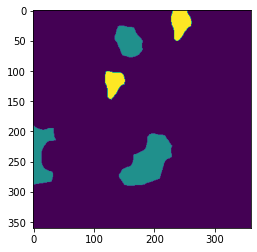

In [232]:
plt.imshow(Image.open("/work/jcardenuto/translate-forgery-algs/python-CMFD-adaptative-oversegmentation/python/results_new/simple/forgery/duplication/copy-move/random/00230/figure_forgery_final_map_ids.png"))

In [1]:
# Including path to forgery_lib dataset on the notebook
# LIB_PATH = "../"
# import sys
# sys.path.append(LIB_PATH)

from glob import glob
import cv2
import numpy as np
from prettytable import PrettyTable
import os 
from metrics import (F1, precision, F1_CTP, precision_CTP)
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import pandas as pd

# Run Evaluation on the TESTSET - Simple Figures

### Duplication

In [2]:
def vole_evaluation(result, gt_pristine, gt_forgery):
    """
    Evaluates the output from the method Christlein et al. (2012) “An evaluation of popular
    copy-move forgery detection approaches". For this we use a modified version inside 
    the detection_method directory in this from this repository.
    
    """
    
    result = cv2.imread(result, cv2.IMREAD_GRAYSCALE)
    
    # Insert pristine regions and forgery regions in the same map
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc


def patch_match_evaluation(result, gt_pristine, gt_forgery):
    """
    Evaluates the output from the method from Cozzolino et al. (2015) “Efficient dense-field 
    copy-move forgery detection”, from the implemented version of Ehret (2018), “Automatic detection of internal copy-move
    forgeries in images”. For this we use a modified version inside the detection_method directory in this from this repository.
    
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = np.fromfile(result,np.int32).reshape(gt_pristine.shape).astype("uint8")
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def busternet_evaluation(result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Wu et al. (2018) "Busternet: Detecting image copy-move forgery with source/target localization".
    To generate the ouput, we used the pre-trained model from https://github.com/isi-vista/BusterNet
    """
    
    result = cv2.imread(result_path)
    # Make the output of busternet as binary
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB).astype("uint8")
    output_format = np.zeros((result.shape[0],result.shape[1])).astype("uint8")
    # If the color of the output is RED or GREEN insert it on output_format
    output_format[ result[:,:,0] > 100] = 1
    output_format[ result[:,:,1] > 100] = 1
    result = output_format
    
    if 'pristine' in result_path:
        gt_forgery = np.zeros((result.shape[0],result.shape[1])).astype("uint8")
        
    else:     
        gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
        gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
        
        # Pre-process gt_forgery as the output of busternet
        gt_forgery [ gt_pristine > 0] = 1
        gt_forgery = cv2.resize(gt_forgery, (result.shape[1],result.shape[0]))
        gt_forgery[gt_forgery > 0] = 1
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def overseg_evaluation(result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Pun et al. (2015) "Image forgery detection using adaptive over-segmentation and feature points matching".
    We base our implementation in the Pun et al. article and in the MatLab code from the github user MohenseZandi
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def hfpm_evaluation (result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Pun et al. (2015) "Fast and Effective Image Copy-Move Forgery Detection via Hierarchical Feature Point Matching".
    We base our implementation in the Yuanman et al. article and in the original Matlab code https://github.com/YuanmanLi/FE-CMFD-HFPM
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def check_output(detection_output, gt_forgery, gt_pristine, method):
    
    if not os.path.isfile(detection_output):
        return (0,0,0,0)
    
    if method == 'vole':
        return vole_evaluation(detection_output, gt_pristine, gt_forgery)
    elif method == 'pm': #patchmacth
        return patch_match_evaluation(detection_output, gt_pristine, gt_forgery)
    elif method == 'busternet':
        return busternet_evaluation (detection_output, gt_pristine, gt_forgery)
    elif method == 'overseg':
        return overseg_evaluation (detection_output, gt_pristine, gt_forgery)
    elif method == 'hfpm':
        return hfpm_evaluation (detection_output, gt_pristine, gt_forgery)
    
    return (0,0,0,0)
        

# Evaluating Copy-Move Simple Figures
Here we evaluate copy move images for duplication propose and for cleaning propose.

In a duplication forgery, an object is paste on the top of a background region

In a cleaning forgery, a background region is pasted on the top of a object (hidden the object).

-----
### Detection Methods
- SURF
- SIFT
- Zernike using PatchMatch
- Sift using PatchMatch

In [5]:
test_path = '/work/jcardenuto/translate-forgery-algs/tmp/'
test_simple_figures = glob(f'{test_path}testset/simple/forgery/cleaning/bf/**/annotations.json',recursive=True) + glob(f'{test_path}testset/simple/forgery/duplication/copy-move/**/annotations.json',recursive=True)
test_simple_figures = [t.replace(test_path,'') for t in test_simple_figures]

In [4]:
SIMPLE_EVAL = pd.DataFrame(columns=['F1','F1-Check','Precision','Precision-Check','Method', "Detection-Map"])

for test_figure in tqdm(test_simple_figures):
    gt_forgery = test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_forgery_gt.png"
    gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_gt.png"
    
    surf_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_surf_figure_forgery_labeled.png"
    sift_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_sift_figure_forgery_labeled.png"
    sift_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_sift_figure_forgery.png.bin"
    zernike_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_zernik_figure_forgery.png.bin"
    busternet = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "busternet_figure_forgery.png"
    overseg = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "overseg_figure_forgery_detection_map.png"
    hfpm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "hfpm_figure_forgery_detection_map.png"
    
    
    f1, f1_cc ,p, p_cc = check_output(surf_vole, gt_pristine, gt_forgery,'vole')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SURF-VOLE', "Detection-Map": surf_vole}))
    
    f1, f1_cc ,p, p_cc = check_output(sift_vole, gt_pristine, gt_forgery,'vole')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-VOLE', "Detection-Map": sift_vole}))
    
    f1, f1_cc ,p, p_cc = check_output(sift_pm, gt_pristine, gt_forgery,'pm')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-PM', "Detection-Map": sift_pm}))
    
    f1, f1_cc ,p, p_cc = check_output(zernike_pm, gt_pristine, gt_forgery,'pm')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'ZERNIKE-PM', "Detection-Map": zernike_pm}))
    
    f1, f1_cc ,p, p_cc = check_output(busternet, gt_pristine, gt_forgery,'busternet')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'BUSTERNET', "Detection-Map": busternet}))
    
    f1, f1_cc ,p, p_cc = check_output(overseg, gt_pristine, gt_forgery,'overseg')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'OVERSEG', "Detection-Map": overseg}))
    
    f1, f1_cc ,p, p_cc = check_output(hfpm, gt_pristine, gt_forgery,'hfpm')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'HFPM', "Detection-Map": hfpm}))
    


NameError: name 'test_simple_figures' is not defined

In [215]:
gt_forgery = test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_forgery_map.png"
gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_map.png"
gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
result = cv2.imread(overseg)

In [222]:
test_figure

'testset/simple/forgery/cleaning/bf/00052/annotations.json'

In [216]:
result.shape

(3, 320, 3)

In [18]:
%pylab inline
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


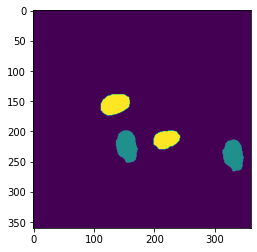

In [19]:
plt.imshow(Image.open("output/simple/forgery/duplication/copy-move/random/00493/overseg_figure_forgery_detection_map.png"))

In [ ]:
SIMPLE_EVAL.sort_values(by=['F1']).iloc[-50:]

In [32]:
SIMPLE_EVAL = SIMPLE_EVAL.reset_index()

In [37]:
SIMPLE_EVAL['MODALITY'] = None

for index, row in SIMPLE_EVAL.iterrows():
    modality = row['Detection-Map']
    modality = "/".join(modality.split("/")[1:-2])
    SIMPLE_EVAL.loc[index, 'MODALITY'] = modality
    

In [51]:
###  Modality - F1 Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - F1 Score CTP (WITH consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 - Score with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - Precision Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)


###  Modality - Precision Score (With consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)

+--------------------------------------------------+------------+---------+-----------+-----------+-----------+---------+---------+
|               Modality - F1 Score                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET | OVERSEG |   HFPM  |
+--------------------------------------------------+------------+---------+-----------+-----------+-----------+---------+---------+
|            simple/forgery/cleaning/bf            |  0.00000   | 0.00942 |  0.00000  |  0.00000  |  0.03551  | 0.00256 | 0.00000 |
|    simple/forgery/duplication/copy-move/flip     |  0.00000   | 0.00853 |  0.00603  |  0.00635  |  0.01951  | 0.01831 | 0.00165 |
|   simple/forgery/duplication/copy-move/random    |  0.08903   | 0.13473 |  0.03028  |  0.04674  |  0.16833  | 0.15595 | 0.04021 |
|  simple/forgery/duplication/copy-move/rotation   |  0.00000   | 0.00741 |  0.00259  |  0.00461  |  0.05191  | 0.06364 | 0.01474 |
| simple/forgery/duplication/copy-move/translation |  0.01138   | 0.04978 | 

In [23]:
print(x.get_csv_string(delimiter='\t'))

Modality - Precision with Check	ZERNIKE-PM	SIFT-PM	SURF-VOLE	SIFT-VOLE	BUSTERNET
simple/forgery/cleaning/bf	0.00000	0.00123	0.00000	0.00000	0.08711
simple/forgery/duplication/copy-move/flip	0.00000	0.00673	0.00768	0.00752	0.05939
simple/forgery/duplication/copy-move/random	0.12031	0.12244	0.05616	0.10193	0.46559
simple/forgery/duplication/copy-move/rotation	0.00000	0.00359	0.00331	0.00597	0.06919
simple/forgery/duplication/copy-move/translation	0.01919	0.03726	0.00375	0.00688	0.17123



In [15]:
from datetime import datetime
# Save CSV file
SIMPLE_EVAL.to_csv(f'simple_eval_{datetime.now().strftime("20%y-%m-%d-%H-%M")}.csv')

# Compound Figures

In [6]:
test_path = '/work/jcardenuto/translate-forgery-algs/tmp/'
test_compound_figures = glob(f'{test_path}testset/compound/**/annotations.json',recursive=True)
test_compound_figures = [t.replace(test_path,'') for t in test_compound_figures]

In [ ]:
def run_parallel(input):
    
    surf_vole, sift_vole, sift_pm, zernike_pm, busternet,overseg, hfpm, gt_pristine, gt_forgery = input
    output = []
    
    f1, f1_cc ,p, p_cc = check_output(surf_vole, gt_pristine, gt_forgery,'vole')
    output.append((f1, f1_cc ,p, p_cc,"SURF-VOLE"))
    
    f1, f1_cc ,p, p_cc = check_output(sift_vole, gt_pristine, gt_forgery,'vole')
    output.append((f1, f1_cc ,p, p_cc,"SIFT-VOLE"))

    f1, f1_cc ,p, p_cc = check_output(sift_pm, gt_pristine, gt_forgery,'pm')
    output.append((f1, f1_cc ,p, p_cc,"SIFT-PM"))
    
    f1, f1_cc ,p, p_cc = check_output(zernike_pm, gt_pristine, gt_forgery,'pm')
    output.append((f1, f1_cc ,p, p_cc,"ZERNIKE-PM"))
    
    f1, f1_cc ,p, p_cc = check_output(busternet, gt_pristine, gt_forgery,'busternet')
    output.append((f1, f1_cc ,p, p_cc,"BUSTERNET"))
        
    f1, f1_cc ,p, p_cc = check_output(overseg, gt_pristine, gt_forgery,'overseg')
    output.append((f1, f1_cc ,p, p_cc,"OVERSEG"))

    f1, f1_cc ,p, p_cc = check_output(hfpm, gt_pristine, gt_forgery,'hfpm')
    output.append((f1, f1_cc ,p, p_cc,"HFPM"))
    
    return output
    
#COMPOUND_EVAL = pd.DataFrame(columns=['F1','Precision','Method', "Detection-Map"])
input_list = []
for test_figure in tqdm(test_compound_figures):
    
    if 'splicing' in test_figure:
        gt_forgery =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_host_gt.png"
        gt_pristine =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_donor_gt.png"
        
    else:
        gt_forgery = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_forgery_gt.png"
        gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_gt.png"
    
    surf_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_surf_figure_v1_labeled.png"
    sift_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_sift_figure_v1_labeled.png"
    sift_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_sift_figure_v1.png.bin"
    zernike_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_zernik_figure_v1.png.bin"
    busternet = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "busternet_figure_v1_forgery.png"
    overseg = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "overseg_figure_v1_detection_map.png"
    hfpm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "hfpm_figure_v1_detection_map.png"
    
    input_list.append((surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery))

In [ ]:
output_list = process_map(run_parallel, input_list, chunksize=1, max_workers=70)

# Continue from here

In [ ]:
COMPOUND_EVAL = pd.DataFrame(columns=['F1','F1-Check', 'Precision', 'Precision-Check','Method', "Detection-Map"])
for index, item in enumerate(output_list):
    
    surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery = input_list[index]
    f1, f1_cc, p, p_cc = item[0][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SURF-VOLE', "Detection-Map": surf_vole}))
    
    f1, f1_cc, p, p_cc = item[1][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-VOLE', "Detection-Map": sift_vole}))
    
    f1, f1_cc, p, p_cc = item[2][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-PM', "Detection-Map": sift_pm}))
    
    f1, f1_cc, p, p_cc = item[3][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'ZERNIKE-PM', "Detection-Map": zernike_pm}))
    
    f1, f1_cc, p, p_cc = item[4][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'BUSTERNET', "Detection-Map": busternet}))
    
    f1, f1_cc, p, p_cc = item[5][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'OVERSEG', "Detection-Map": overseg}))
    
    f1, f1_cc, p, p_cc = item[6][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'HFPM', "Detection-Map": hfpm}))
    

In [77]:
COMPOUND_EVAL.sort_values(by=['F1']).iloc[-50:]

,F1,F1-Check,Precision,Precision-Check,Method,Detection-Map
0,0.0502314,0.0440115,0.0259739,0.0227576,OVERSEG,output/compound/inter-panel/duplication/splici...
0,0.0509603,0.0509603,0.0261477,0.0261477,BUSTERNET,output/compound/inter-panel/duplication/splici...
0,0.0519167,0.0519167,0.0266508,0.0266508,BUSTERNET,output/compound/inter-panel/duplication/splici...
0,0.0520827,0.0444318,0.0282492,0.0240994,OVERSEG,output/compound/inter-panel/duplication/splici...
0,0.0553462,0.0525687,0.0319312,0.0303288,SIFT-PM,output/compound/inter-panel/duplication/splici...
0,0.0589927,0.0589927,0.0303928,0.0303928,BUSTERNET,output/compound/inter-panel/duplication/splici...
0,0.0611973,0.0611973,0.0351856,0.0351856,OVERSEG,output/compound/inter-panel/duplication/splici...
0,0.0633534,0.0633534,0.0327146,0.0327146,OVERSEG,output/compound/inter-panel/duplication/splici...
0,0.0643907,0.0643907,0.033391,0.033391,BUSTERNET,output/compound/inter-panel/duplication/splici...
0,0.0649614,0.0573561,0.0339516,0.0299768,OVERSEG,output/compound/inter-panel/duplication/splici...


In [ ]:
COMPOUND_EVAL = COMPOUND_EVAL.reset_index()

In [ ]:
from datetime import datetime
# Save CSV file
COMPOUND_EVAL.to_csv(f'compound_v1_{datetime.now().strftime("20%y-%m-%d-%H-%M")}.csv')

In [ ]:
modalities = set([os.path.dirname(os.path.dirname(i[0])) for i in input_list])

In [19]:
COMPOUND_EVAL = pd.read_csv('compound_v1_2022-02-24-13-11.csv')

In [ ]:
COMPOUND_EVAL['MODALITY'] = None

for index, row in COMPOUND_EVAL.iterrows():
    modality = row['Detection-Map']
    modality = "/".join(modality.split("/")[1:-2])
    COMPOUND_EVAL.loc[index, 'MODALITY'] = modality
    

# Verbosity - 1

In [ ]:
###  Modality - F1 Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - F1 Score CTP (WITH consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 - Score with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - Precision Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)


###  Modality - Precision Score (With consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)

# print(x.get_csv_string(delimiter='\t'))

In [17]:
x = PrettyTable()
x.field_names = ["Modality - F1 Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - F1 Check                                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00038   | 0.04879 |  0.03346  |  0.03735  |  0.13116  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.00849   | 0.00703 |  0.00541  |  0.01256  |  0.11566  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.06647   | 0.55762 |  0.56854  |  0.59223  |  0.14261  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.01377 |  0.66468  |  0.57795  |  0.1

In [18]:
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - Precision                               | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.01529   | 0.10145 |  0.08281  |  0.08047  |  0.10723  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01389   | 0.03940 |  0.01726  |  0.03493  |  0.08231  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.10861   | 0.50043 |  0.60406  |  0.65120  |  0.11678  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00649   | 0.06457 |  0.71429  |  0.69892  |  0.0

In [19]:
x = PrettyTable()
x.field_names = ["Modality - Precision Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                            Modality - Precision Check                            | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00234   | 0.07919 |  0.07244  |  0.07683  |  0.07934  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01080   | 0.01432 |  0.01522  |  0.03257  |  0.06743  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.09992   | 0.47748 |  0.59983  |  0.65117  |  0.08887  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.02494 |  0.71010  |  0.69892  |  0.0

# Verbosity - 2

In [7]:
input_list = []
for test_figure in tqdm(test_compound_figures):
    
    if 'splicing' in test_figure:
        gt_forgery =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_host_gt.png"
        gt_pristine =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_donor_gt.png"
        
    else:
        gt_forgery = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_forgery_gt.png"
        gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_gt.png"
    
    surf_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_surf_figure_v2_labeled.png"
    sift_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_sift_figure_v2_labeled.png"
    sift_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_sift_figure_v2.png.bin"
    zernike_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_zernik_figure_v2.png.bin"
    busternet = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "busternet_figure_v2_forgery.png"
    overseg = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "overseg_figure_v2_detection_map.png"
    hfpm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "hfpm_figure_v2_detection_map.png"
    
    input_list.append((surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery))

In [8]:
output_list = process_map(run_parallel, input_list, chunksize=1, max_workers=70)

libpng error: bad adaptive filter value


Process ForkProcess-16:
Process ForkProcess-67:
Process ForkProcess-46:
Process ForkProcess-7:
Process ForkProcess-13:
Process ForkProcess-28:
Process ForkProcess-12:
Process ForkProcess-49:
Process ForkProcess-62:
Process ForkProcess-66:
Process ForkProcess-58:
Process ForkProcess-60:
Process ForkProcess-54:
Process ForkProcess-45:
Process ForkProcess-55:
Process ForkProcess-19:
Process ForkProcess-47:
Process ForkProcess-10:
Process ForkProcess-18:
Process ForkProcess-64:
Process ForkProcess-6:
Process ForkProcess-4:
Process ForkProcess-11:
Process ForkProcess-50:
Process ForkProcess-65:
Process ForkProcess-22:
Process ForkProcess-24:
Process ForkProcess-25:
Process ForkProcess-8:
Process ForkProcess-61:
Process ForkProcess-21:
Process ForkProcess-2:
Process ForkProcess-14:
Process ForkProcess-20:
Process ForkProcess-44:
Process ForkProcess-48:
Process ForkProcess-56:
Process ForkProcess-27:
Process ForkProcess-3:
Process ForkProcess-30:
Process ForkProcess-31:
Process ForkProcess-43

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jcardenuto/anaconda3/envs/py3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jcardenuto/anaconda3/envs/py3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jcardenuto/anaconda3/envs/py3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/jcardenuto/anaconda3/envs/py3/lib/python3.7/mult

In [ ]:
COMPOUND_EVAL = pd.DataFrame(columns=['F1','F1-Check', 'Precision', 'Precision-Check','Method', "Detection-Map"])
for index, item in enumerate(output_list):
    
    surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery = input_list[index]
    f1, f1_cc, p, p_cc = item[0][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SURF-VOLE', "Detection-Map": surf_vole}))
    
    f1, f1_cc, p, p_cc = item[1][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-VOLE', "Detection-Map": sift_vole}))
    
    f1, f1_cc, p, p_cc = item[2][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-PM', "Detection-Map": sift_pm}))
    
    f1, f1_cc, p, p_cc = item[3][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'ZERNIKE-PM', "Detection-Map": zernike_pm}))
    
    f1, f1_cc, p, p_cc = item[4][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'BUSTERNET', "Detection-Map": busternet}))
    
    f1, f1_cc, p, p_cc = item[5][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'OVERSEG', "Detection-Map": overseg}))
    
    f1, f1_cc, p, p_cc = item[6][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'HFPM', "Detection-Map": hfpm}))
    

In [ ]:
COMPOUND_EVAL.sort_values(by=['F1']).iloc[-50:]

In [ ]:
COMPOUND_EVAL = COMPOUND_EVAL.reset_index()

In [ ]:
from datetime import datetime
# Save CSV file
COMPOUND_EVAL.to_csv(f'compound_v2_{datetime.now().strftime("20%y-%m-%d-%H-%M")}.csv')

In [ ]:
modalities = set([os.path.dirname(os.path.dirname(i[0])) for i in input_list])

In [ ]:
COMPOUND_EVAL['MODALITY'] = None

for index, row in COMPOUND_EVAL.iterrows():
    modality = row['Detection-Map']
    modality = "/".join(modality.split("/")[1:-2])
    COMPOUND_EVAL.loc[index, 'MODALITY'] = modality
    

In [ ]:
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['F1', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

In [49]:
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - F1 Score                                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00045   | 0.04599 |  0.02605  |  0.01235  |  0.13310  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.00877   | 0.00583 |  0.00465  |  0.00740  |  0.11234  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.06579   | 0.54962 |  0.53500  |  0.53133  |  0.14219  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.01417 |  0.62237  |  0.49125  |  0.1

In [50]:
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - Precision                               | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.01284   | 0.09980 |  0.07479  |  0.05282  |  0.10712  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01605   | 0.04258 |  0.02293  |  0.03721  |  0.08208  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.11463   | 0.51408 |  0.57047  |  0.59574  |  0.11658  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00342   | 0.06558 |  0.67366  |  0.59710  |  0.0

In [51]:
x = PrettyTable()
x.field_names = ["Modality - Precision Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                            Modality - Precision Score                            | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00079   | 0.07701 |  0.05762  |  0.03308  |  0.08068  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01355   | 0.01303 |  0.01448  |  0.01473  |  0.06564  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.10740   | 0.47788 |  0.56340  |  0.58900  |  0.08873  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.02999 |  0.66826  |  0.58594  |  0.0

# Verbosity - 3

In [ ]:
#COMPOUND_EVAL = pd.DataFrame(columns=['F1','Precision','Method', "Detection-Map"])
input_list = []
for test_figure in tqdm(test_compound_figures):
    
    if 'splicing' in test_figure:
        gt_forgery =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_host_gt.png"
        gt_pristine =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_donor_gt.png"
        
    else:
        gt_forgery = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_forgery_gt.png"
        gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_gt.png"
    
    surf_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_surf_figure_v3_labeled.png"
    sift_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_sift_figure_v3_labeled.png"
    sift_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_sift_figure_v3.png.bin"
    zernike_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_zernik_figure_v3.png.bin"
    busternet = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "busternet_figure_v3_forgery.png"
    overseg = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "overseg_figure_v3_detection_map.png"
    hfpm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "hfpm_figure_v3_detection_map.png"
    
    input_list.append((surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery))

In [ ]:
output_list = process_map(run_parallel, input_list, chunksize=1, max_workers=70)

In [ ]:
COMPOUND_EVAL = pd.DataFrame(columns=['F1','F1-Check', 'Precision', 'Precision-Check','Method', "Detection-Map"])
for index, item in enumerate(output_list):
    
    surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery = input_list[index]
    f1, f1_cc, p, p_cc = item[0][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SURF-VOLE', "Detection-Map": surf_vole}))
    
    f1, f1_cc, p, p_cc = item[1][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-VOLE', "Detection-Map": sift_vole}))
    
    f1, f1_cc, p, p_cc = item[2][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-PM', "Detection-Map": sift_pm}))
    
    f1, f1_cc, p, p_cc = item[3][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'ZERNIKE-PM', "Detection-Map": zernike_pm}))
    
    f1, f1_cc, p, p_cc = item[4][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'BUSTERNET', "Detection-Map": busternet}))
    
    f1, f1_cc, p, p_cc = item[5][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'OVERSEG', "Detection-Map": overseg}))
    
    f1, f1_cc, p, p_cc = item[6][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'HFPM', "Detection-Map": hfpm}))
    

In [ ]:
COMPOUND_EVAL = COMPOUND_EVAL.reset_index()

In [ ]:
from datetime import datetime
# Save CSV file
COMPOUND_EVAL.to_csv(f'compound_v3_{datetime.now().strftime("20%y-%m-%d-%H-%M")}.csv')

In [244]:
modalities = set([os.path.dirname(os.path.dirname(i[0])) for i in input_list])

In [15]:
#COMPOUND_EVAL = pd.read_csv('compound_v3.csv')

In [16]:
COMPOUND_EVAL['MODALITY'] = None

for index, row in COMPOUND_EVAL.iterrows():
    modality = row['Detection-Map']
    modality = "/".join(modality.split("/")[1:-2])
    COMPOUND_EVAL.loc[index, 'MODALITY'] = modality
    

In [21]:
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['F1', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)


+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - F1 Score                                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00141   | 0.06400 |  0.03005  |  0.01820  |  0.17294  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.00826   | 0.01953 |  0.00722  |  0.01116  |  0.13658  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.06750   | 0.58851 |  0.52869  |  0.52754  |  0.18360  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00050   | 0.03935 |  0.61875  |  0.48998  |  0.1

In [27]:
print(x.get_csv_string(delimiter='\t'))

Modality - F1 Score	ZERNIKE-PM	SIFT-PM	SURF-VOLE	SIFT-VOLE	BUSTERNET
compound/inter-panel/duplication/copy-move/geometric_transformations/flip	0.00141	0.06400	0.03005	0.01820	0.17294
compound/inter-panel/duplication/copy-move/geometric_transformations/flip90	0.00826	0.01953	0.00722	0.01116	0.13658
compound/inter-panel/duplication/copy-move/geometric_transformations/none	0.06750	0.58851	0.52869	0.52754	0.18360
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180	0.00050	0.03935	0.61875	0.48998	0.16031
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation90	0.00088	0.01846	0.31233	0.36353	0.15079
compound/inter-panel/duplication/copy-move/retouching_and_cleaning	0.51143	0.52842	0.37785	0.30451	0.16382
compound/inter-panel/duplication/overlap/center	0.00000	0.00231	0.03739	0.06990	0.06851
compound/inter-panel/duplication/overlap/none	0.00000	0.00339	0.00842	0.02606	0.10144
compound/inter-panel/duplication/overlap/top_left	0.00000	0.00764

In [34]:
x = PrettyTable()
x.field_names = ["Modality - F1 Score - Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)


+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                           Modality - F1 Score - Check                            | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00032   | 0.04644 |  0.02580  |  0.01461  |  0.13165  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.00826   | 0.00612 |  0.00377  |  0.00609  |  0.11341  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.06649   | 0.54451 |  0.52426  |  0.52094  |  0.14206  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.01395 |  0.61535  |  0.48543  |  0.1

In [35]:
print(x.get_csv_string(delimiter='\t'))

Modality - F1 Score - Check	ZERNIKE-PM	SIFT-PM	SURF-VOLE	SIFT-VOLE	BUSTERNET
compound/inter-panel/duplication/copy-move/geometric_transformations/flip	0.00032	0.04644	0.02580	0.01461	0.13165
compound/inter-panel/duplication/copy-move/geometric_transformations/flip90	0.00826	0.00612	0.00377	0.00609	0.11341
compound/inter-panel/duplication/copy-move/geometric_transformations/none	0.06649	0.54451	0.52426	0.52094	0.14206
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180	0.00000	0.01395	0.61535	0.48543	0.12784
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation90	0.00000	0.00432	0.31066	0.35819	0.11846
compound/inter-panel/duplication/copy-move/retouching_and_cleaning	0.50801	0.48159	0.37561	0.29631	0.12387
compound/inter-panel/duplication/overlap/center	0.00000	0.00130	0.03711	0.06733	0.03802
compound/inter-panel/duplication/overlap/none	0.00000	0.00030	0.00809	0.02189	0.06425
compound/inter-panel/duplication/overlap/top_left	0.00000

In [36]:
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)


+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - Precision                               | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.01368   | 0.10566 |  0.07002  |  0.05826  |  0.10712  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01166   | 0.03900 |  0.02151  |  0.03111  |  0.08209  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.11480   | 0.50811 |  0.56987  |  0.58722  |  0.11658  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00336   | 0.07089 |  0.66984  |  0.59418  |  0.0

In [37]:
print(x.get_csv_string(delimiter='\t'))

Modality - Precision	ZERNIKE-PM	SIFT-PM	SURF-VOLE	SIFT-VOLE	BUSTERNET
compound/inter-panel/duplication/copy-move/geometric_transformations/flip	0.01368	0.10566	0.07002	0.05826	0.10712
compound/inter-panel/duplication/copy-move/geometric_transformations/flip90	0.01166	0.03900	0.02151	0.03111	0.08209
compound/inter-panel/duplication/copy-move/geometric_transformations/none	0.11480	0.50811	0.56987	0.58722	0.11658
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180	0.00336	0.07089	0.66984	0.59418	0.09791
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation90	0.00818	0.04103	0.39178	0.46138	0.09158
compound/inter-panel/duplication/copy-move/retouching_and_cleaning	0.65263	0.48071	0.45435	0.38621	0.09918
compound/inter-panel/duplication/overlap/center	0.00000	0.00205	0.04953	0.09105	0.03859
compound/inter-panel/duplication/overlap/none	0.00000	0.00410	0.01334	0.03773	0.05790
compound/inter-panel/duplication/overlap/top_left	0.00000	0.0102

In [38]:
x = PrettyTable()
x.field_names = ["Modality - Precision Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)


+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                            Modality - Precision Check                            | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00358   | 0.08126 |  0.05732  |  0.04085  |  0.07954  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01166   | 0.01210 |  0.01139  |  0.01127  |  0.06617  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.10649   | 0.47219 |  0.56229  |  0.57836  |  0.08877  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.02893 |  0.66460  |  0.58568  |  0.0

In [39]:
print(x.get_csv_string(delimiter='\t'))

Modality - Precision Check	ZERNIKE-PM	SIFT-PM	SURF-VOLE	SIFT-VOLE	BUSTERNET
compound/inter-panel/duplication/copy-move/geometric_transformations/flip	0.00358	0.08126	0.05732	0.04085	0.07954
compound/inter-panel/duplication/copy-move/geometric_transformations/flip90	0.01166	0.01210	0.01139	0.01127	0.06617
compound/inter-panel/duplication/copy-move/geometric_transformations/none	0.10649	0.47219	0.56229	0.57836	0.08877
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180	0.00000	0.02893	0.66460	0.58568	0.07698
compound/inter-panel/duplication/copy-move/geometric_transformations/rotation90	0.00000	0.01002	0.38799	0.44695	0.06912
compound/inter-panel/duplication/copy-move/retouching_and_cleaning	0.64580	0.43426	0.45003	0.37056	0.07279
compound/inter-panel/duplication/overlap/center	0.00000	0.00121	0.04916	0.08677	0.02026
compound/inter-panel/duplication/overlap/none	0.00000	0.00043	0.01252	0.03113	0.03458
compound/inter-panel/duplication/overlap/top_left	0.00000	